In [1]:
library(devtools)
library(ggridges)
library(dplyr)
library(tidyr)
library(ggplot2)
library(quantmod)
library(xts)
library(zoo)
library(gridExtra)
library(tidyverse)
library(tibble)
library(grid)
library(DescTools)

set.seed(1)
load_all("../../../hmmTMB")
source("markets_functions.R")  # adjust path if the notebook’s cwd differs

plot_folder <- "TSX-covariates_no_horseshoe"

Loading required package: usethis


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #
# conflictRules('dplyr', ex

[1] 14

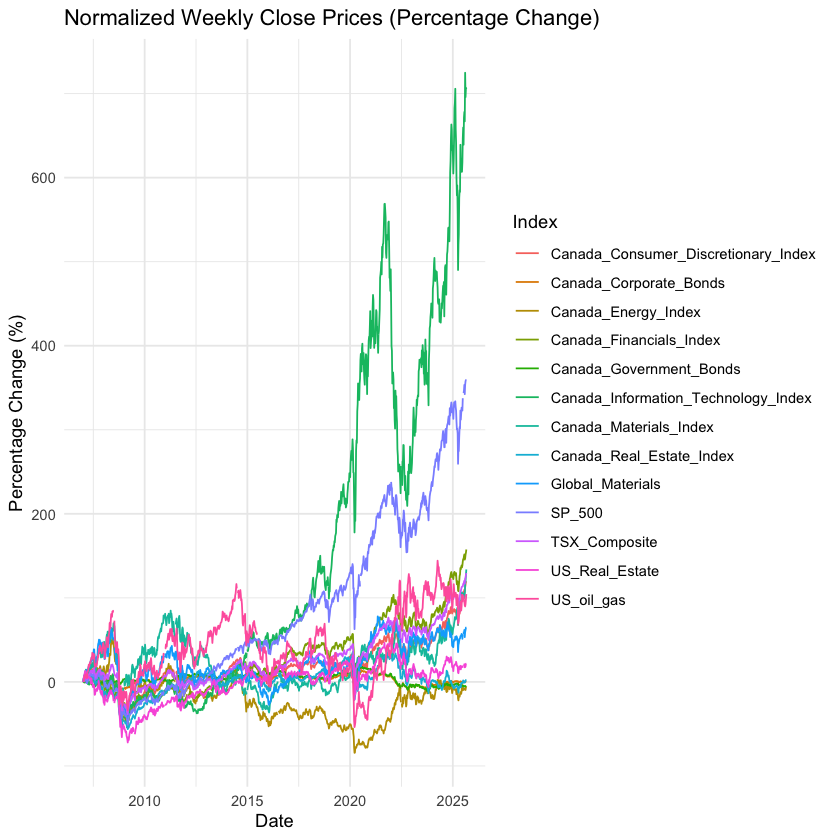

In [3]:

close_data <- get_markets_data("2007-01-01", "2025-09-01", "weeks")

# Reshape data for ggplot
close_data_long <- close_data %>%
  mutate(Date = rownames(close_data)) %>%
  pivot_longer(-Date, names_to = "Index", values_to = "Close") %>%
  group_by(Index) %>%
  mutate(Close = (Close / first(Close) - 1) * 100) %>%  # Normalize as percentage change
  mutate(Date = as.Date(Date))

# Plot using ggplot2
ggplot(close_data_long, aes(x = Date, y = Close, color = Index)) +
  geom_line() +
  labs(title = "Normalized Weekly Close Prices (Percentage Change)", x = "Date", y = "Percentage Change (%)") +
  theme_minimal()

ncol(close_data)

# TSX model with Covariates

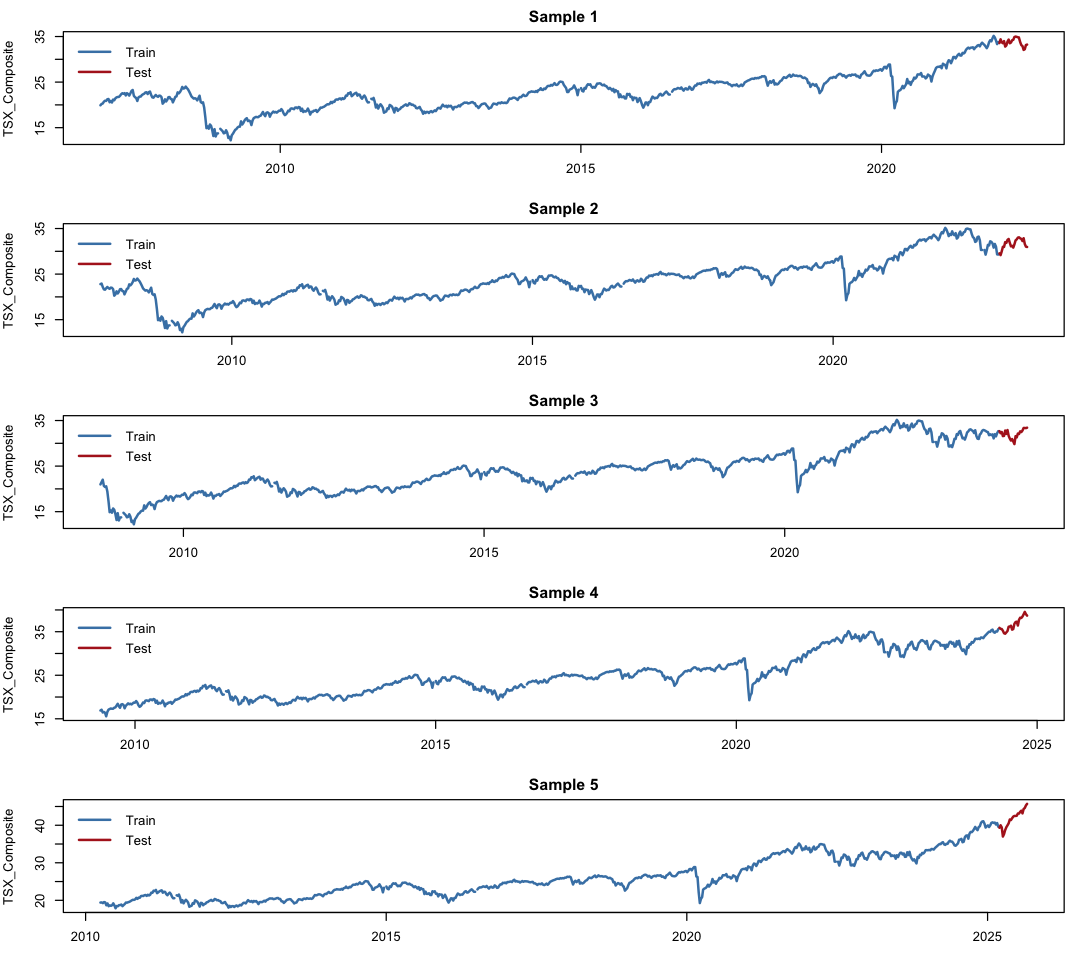

In [4]:
splits <- train_test_split(
  close_data,
  training_period_w = 780,
  testing_period_w = 25,
  samples = 5
)

options(repr.plot.width = 9, repr.plot.height = 8)  # Adjust figure size

plot_train_test_samples(splits,
  y_column = "TSX_Composite",
  savefig = paste0(plot_folder, "/train_test_split_TSX_Composite.png"))
plot_train_test_samples(splits,
  y_column = "TSX_Composite")

Loading required package: DescTools



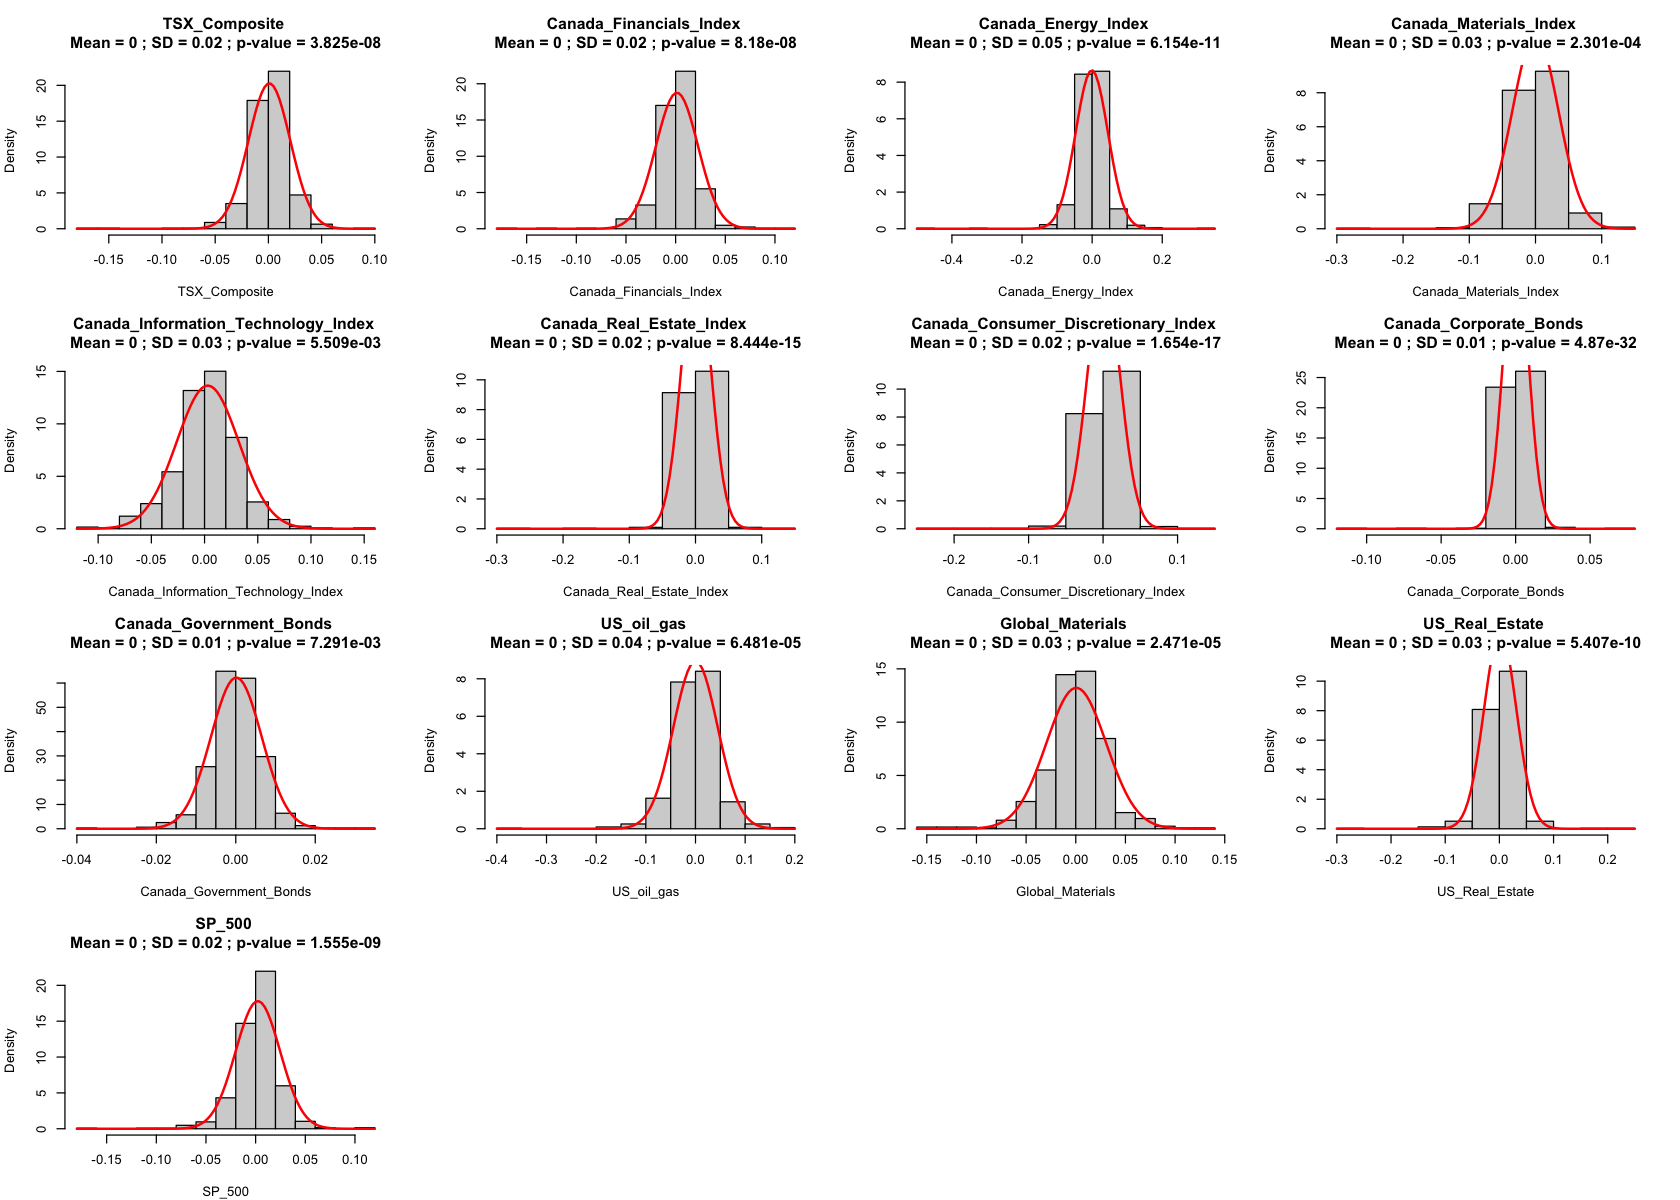

In [ ]:
# Assuming train_data_log is a data frame (as matrices in R cannot have mixed types).
# If it is truly a matrix, convert it to a data frame first: train_data_log <- as.data.frame(train_data_log)

# Identify numeric columns
num_cols <- names(train_data_log)[sapply(train_data_log, is.numeric)]

# Function to compute p-value using DescTools::PearsonTest
compute_pval <- function(x) {
  x <- na.omit(x)  # Remove NAs
  if (length(x) < 10 || length(unique(x)) < 2) {
    return(NA)  # Insufficient data or constant values
  }
  res <- tryCatch(PearsonTest(x), error = function(e) NA)
  if (is.null(res)) return(NA)
  return(res$p.value)
}

# Create helper data frame with statistics
helper_df <- data.frame(
  covariate = num_cols,
  mean = sapply(num_cols, function(col) mean(train_data_log[[col]], na.rm = TRUE)),
  sd = sapply(num_cols, function(col) sd(train_data_log[[col]], na.rm = TRUE)),
  pval = sapply(num_cols, function(col) compute_pval(train_data_log[[col]]))
)

# Set up multi-panel plot layout
n <- length(num_cols)
if (n == 0) {
  stop("No numeric columns found.")
}
rows <- ceiling(sqrt(n))
cols <- ceiling(n / rows)
par(mfrow = c(rows, cols), mar = c(4, 4, 4, 2) + 0.1)  # Adjust margins for titles

options(repr.plot.width = 14, repr.plot.height = 10)  # Adjust figure size

# Generate plots for each numeric column
for (col in num_cols) {
  x <- na.omit(train_data_log[[col]])
  if (length(x) < 2) {
    plot.new()
    title(main = paste(col, "\nInsufficient data for plot"))
    next
  }
  m <- helper_df$mean[helper_df$covariate == col]
  s <- helper_df$sd[helper_df$covariate == col]
  if (s == 0) s <- 1e-10  # Avoid division by zero in dnorm
  p <- helper_df$pval[helper_df$covariate == col]
  p_display <- ifelse(is.na(p), "NA", format(p, digits = 4, scientific = TRUE))
  
  hist(x, prob = TRUE, breaks = "Sturges",
       main = paste(col, "\nMean =", round(m, 2), 
                    "; SD =", round(s, 2), 
                    "; p-value =", p_display),
       xlab = col, ylab = "Density")
  curve(dnorm(x, mean = m, sd = s), 
        add = TRUE, col = "red", lwd = 2)
}

In [5]:
# Rescale each covariate to have a Mean absolute Deviation of 1
helper_df <- helper_df %>%
  mutate(scale_factor = sapply(sd, function(x) ( 1 / x )))
train_data_scaled <- train_data_log %>%
  mutate(across(all_of(setdiff(num_cols, observation)), 
                ~ . * helper_df$scale_factor[helper_df$covariate == cur_column()]))


## No Horseshoe

Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradien

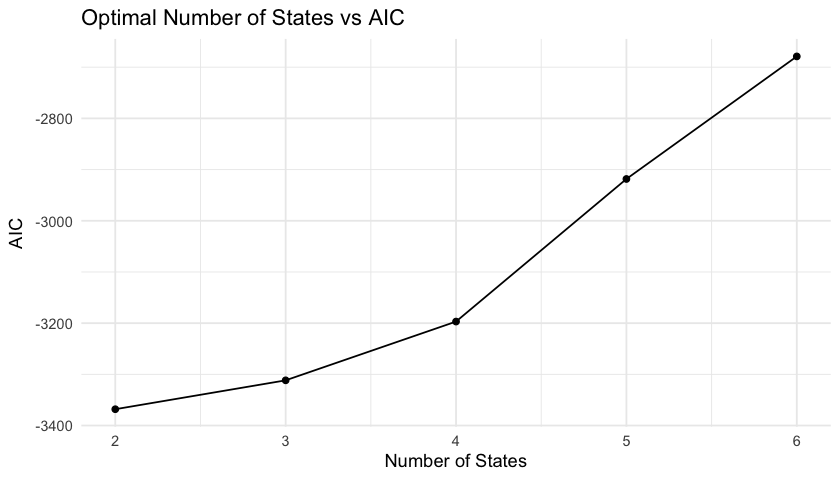

In [ ]:
optimal_n <- data.frame(
  n_states = integer(),
  AIC = numeric()
)
data <- train_data_scaled
cov_colnames <- setdiff(colnames(data), c("Date", observation))
hid_formula <- as.formula(paste("~1 +", paste(cov_colnames, collapse = " + ")))

for (n in 2:5) {
  hmm <- fit_markets_hmm(
    n_states = n,
    data = data,
    obs_name = observation,
    hid_formula = hid_formula,
    horseshoe = FALSE
    )
  optimal_n <- rbind(optimal_n, data.frame(n_states = n, AIC = hmm$AIC_conditional()))
}
options(repr.plot.width = 7, repr.plot.height = 4)  # Adjust figure size
ggplot(optimal_n, aes(x = n_states, y = AIC)) +
  geom_line() +
  geom_point() +
  labs(title = "Optimal Number of States vs AIC", x = "Number of States", y = "AIC") +
  theme_minimal()

In [44]:
hmm_2s <- fit_markets_hmm(
  n_states = 2,
  data = data,
  obs_name = observation,
  hid_formula = hid_formula,
  horseshoe = FALSE
)

hmm_3s <- fit_markets_hmm(
  n_states = 3,
  data = data,
  obs_name = observation,
  hid_formula = hid_formula,
  horseshoe = FALSE
)

Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradien

In [ ]:
extract_hid_fe <- function(hmm) {
  hid_fe <- hmm$hid()$coeff_fe()
  
  hid_fe <- data.frame(hid_fe)
  hid_fe$transition <- sapply(strsplit(rownames(hid_fe), "\\."), `[`, 1)
  hid_fe$covariate  <- sapply(strsplit(rownames(hid_fe), "\\."), `[`, 2)
  
  hid_fe_wide <- hid_fe %>%
    pivot_wider(names_from = covariate, values_from = hid_fe) %>%
    column_to_rownames("transition")
  
  return(hid_fe_wide)
}
hid_fe_2s <- extract_hid_fe(hmm_2s)
hid_fe_3s <- extract_hid_fe(hmm_3s)
hid_fe_s

(Intercept) Canada_Financials_Index Canada_Energy_Index
S1>S2  -17.18951  -11.65499                  0.06880731      
S2>S1 -271.08828   15.13364               -178.74540929      
      Canada_Materials_Index Canada_Information_Technology_Index
S1>S2 5.133392               -7.668648                          
S2>S1 1.454529               -6.474125                          
      Canada_Real_Estate_Index Canada_Consumer_Discretionary_Index
S1>S2   0.06752142             -2.516085                          
S2>S1 252.61996203             40.775048                          
      Canada_Corporate_Bonds Canada_Government_Bonds US_oil_gas
S1>S2 -11.36139               12.81035               -3.561521 
S2>S1 -60.42802              -24.80199               52.129215 
      Global_Materials US_Real_Estate SP_500   
S1>S2   0.793682        -10.73967      9.262505
S2>S1 261.110698       -305.89385     13.712960

In [46]:
hid_fe_3s

(Intercept) Canada_Financials_Index Canada_Energy_Index
S1>S2 -17.560684    7.9914002             -19.1160678        
S1>S3 -38.698555   -3.7834971              -5.0399215        
S2>S1 -23.907817  -14.3161778               1.5186461        
S2>S3 -18.266341   -0.7719930              -0.3508515        
S3>S1  -2.353971   -0.8847809               0.8700486        
S3>S2  -1.590483   -0.1756619              -0.7843240        
      Canada_Materials_Index Canada_Information_Technology_Index
S1>S2 -7.5911513               1.9162626                        
S1>S3 -0.6775956              -2.0386061                        
S2>S1  7.3013548             -10.6774959                        
S2>S3 -0.0353206              -0.7655222                        
S3>S1  2.7185383              -0.3215369                        
S3>S2  2.0560187               2.5507489                        
      Canada_Real_Estate_Index Canada_Consumer_Discretionary_Index
S1>S2  0.76752449               9.098041                          
S1>S3  0.36124274               1.952743                          
S2>S1  1.08377651              -2.899885                          
S2>S3 -0.02805362               0.584953                          
S3>S1  1.22274880               1.531667                          
S3>S2  0.10021585               1.417197                          
      Canada_Corporate_Bonds Canada_Government_Bonds US_oil_gas 
S1>S2 -18.975783              7.096683               14.12546316
S1>S3  -3.103960              5.534253               -4.34378198
S2>S1 -16.583396             18.116956               -6.11100071
S2>S3  -1.031614              1.405860               -0.08688815
S3>S1  -1.692428              3.611052                1.37318100
S3>S2  -1.227146             -0.167900                1.00909546
      Global_Materials US_Real_Estate SP_500     
S1>S2 18.1087509        -8.6871421    -14.1184032
S1>S3  6.3917498         0.2575712      2.2391033
S2>S1  0.5462385       -18.2481011     13.0104015
S2>S3 -0.2004298         1.0433434      0.1611828
S3>S1 -0.3076373        -1.2723982     -1.1586257
S3>S2  2.8710596         2.2036503      1.7842424

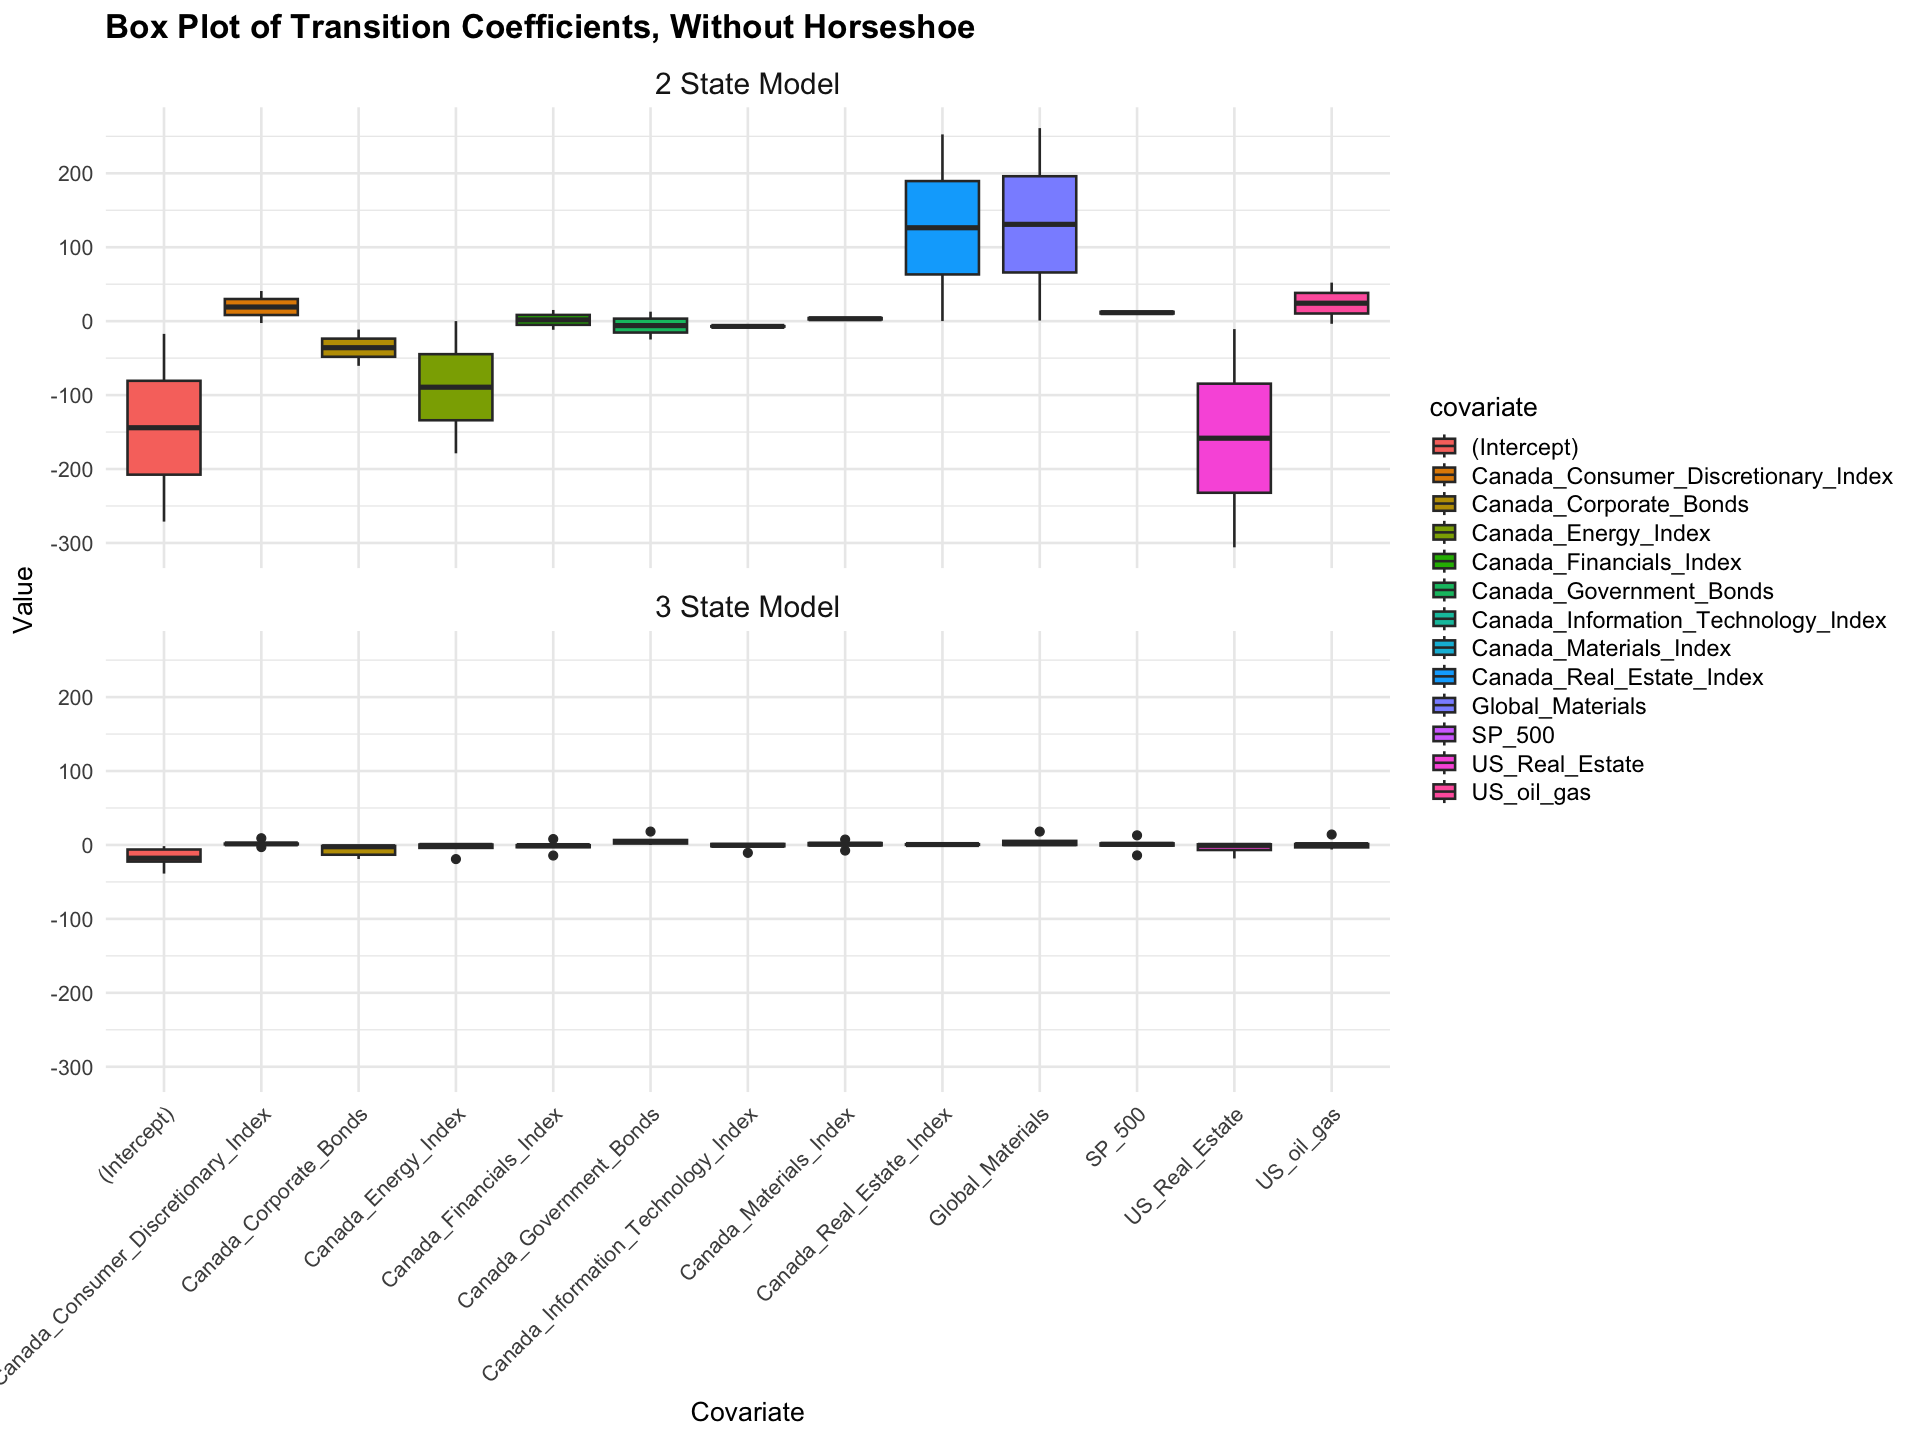

In [47]:
# Reshape hid_fe_2s and hid_fe_3s into long format for ggplot
hid_fe_2s_long <- hid_fe_2s %>%
  rownames_to_column("transition") %>%
  pivot_longer(-transition, names_to = "covariate", values_to = "value") %>%
  mutate(model = "hid_fe_2s")

hid_fe_3s_long <- hid_fe_3s %>%
  rownames_to_column("transition") %>%
  pivot_longer(-transition, names_to = "covariate", values_to = "value") %>%
  mutate(model = "hid_fe_3s")

hid_fe_long <- bind_rows(hid_fe_2s_long, hid_fe_3s_long) %>%
  mutate(model = factor(model, levels = c("hid_fe_2s", "hid_fe_3s"),
                         labels = c("2 State Model", "3 State Model")))

# Plot the boxplot
options(repr.plot.width = 16, repr.plot.height = 12)  # Adjust figure size
ggplot(hid_fe_long, aes(x = covariate, y = value, fill = covariate)) +
  geom_boxplot() +
  facet_wrap(~ model, ncol = 1) +
  labs(title = "Box Plot of Transition Coefficients, Without Horseshoe", x = "Covariate", y = "Value") +
  theme_minimal(base_size = 16) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        strip.text = element_text(size = 18),
        plot.title = element_text(size = 20, face = "bold"),
        legend.title = element_text(size = 16),
        legend.text = element_text(size = 14))


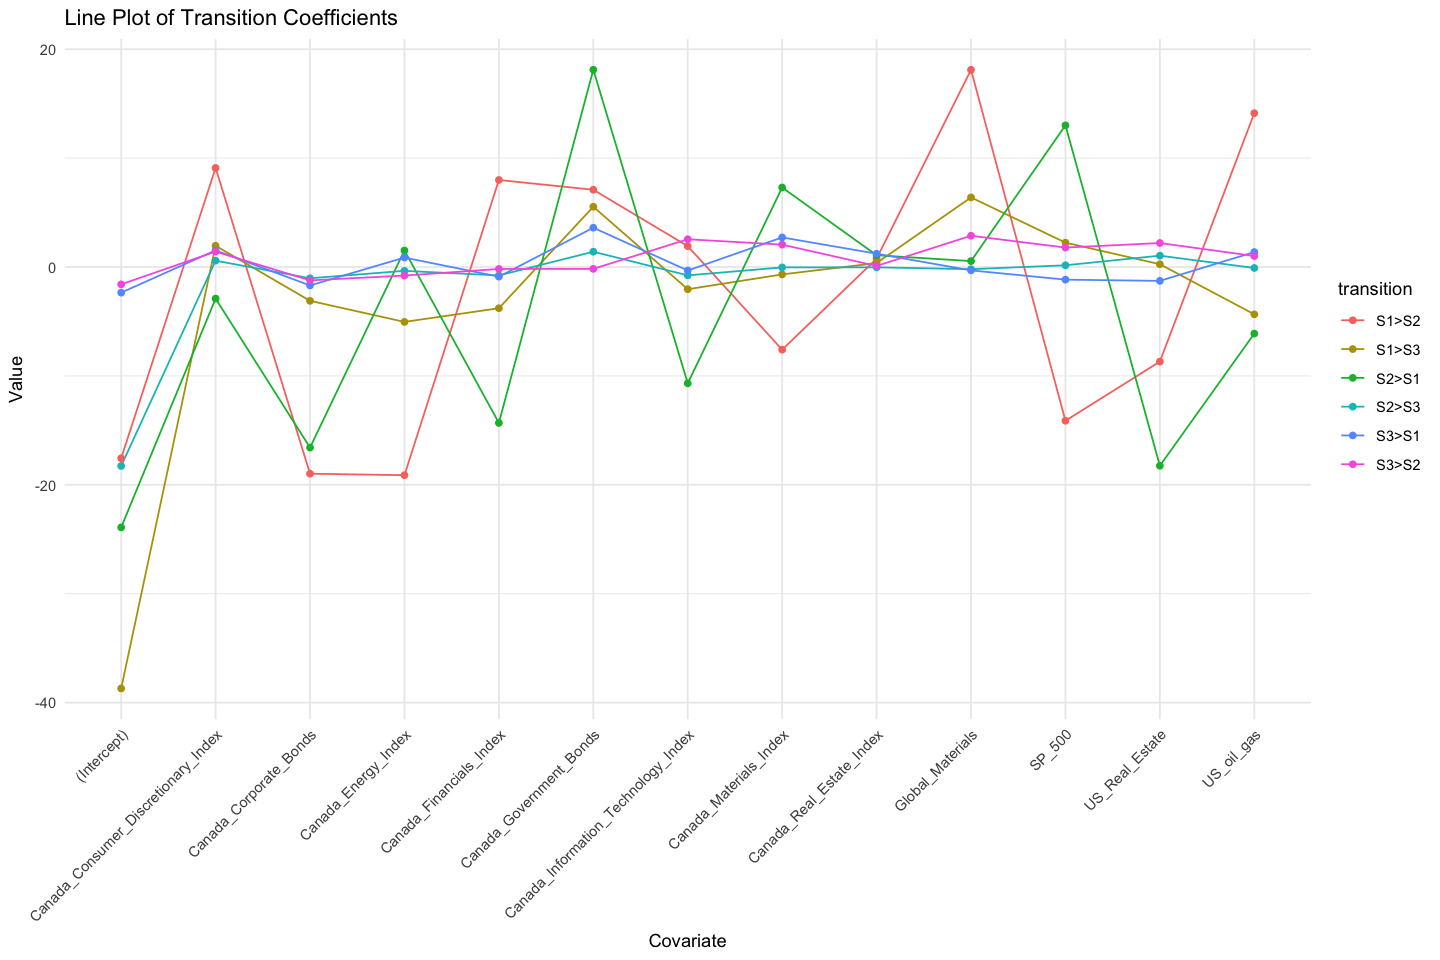

In [48]:
# Plot the line plot
options(repr.plot.width = 12, repr.plot.height = 8)  # Adjust figure size
ggplot(hid_fe_3s_long, aes(x = covariate, y = value, group = transition, color = transition)) +
  geom_line() +
  geom_point() +
  labs(title = "Line Plot of Transition Coefficients", x = "Covariate", y = "Value") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

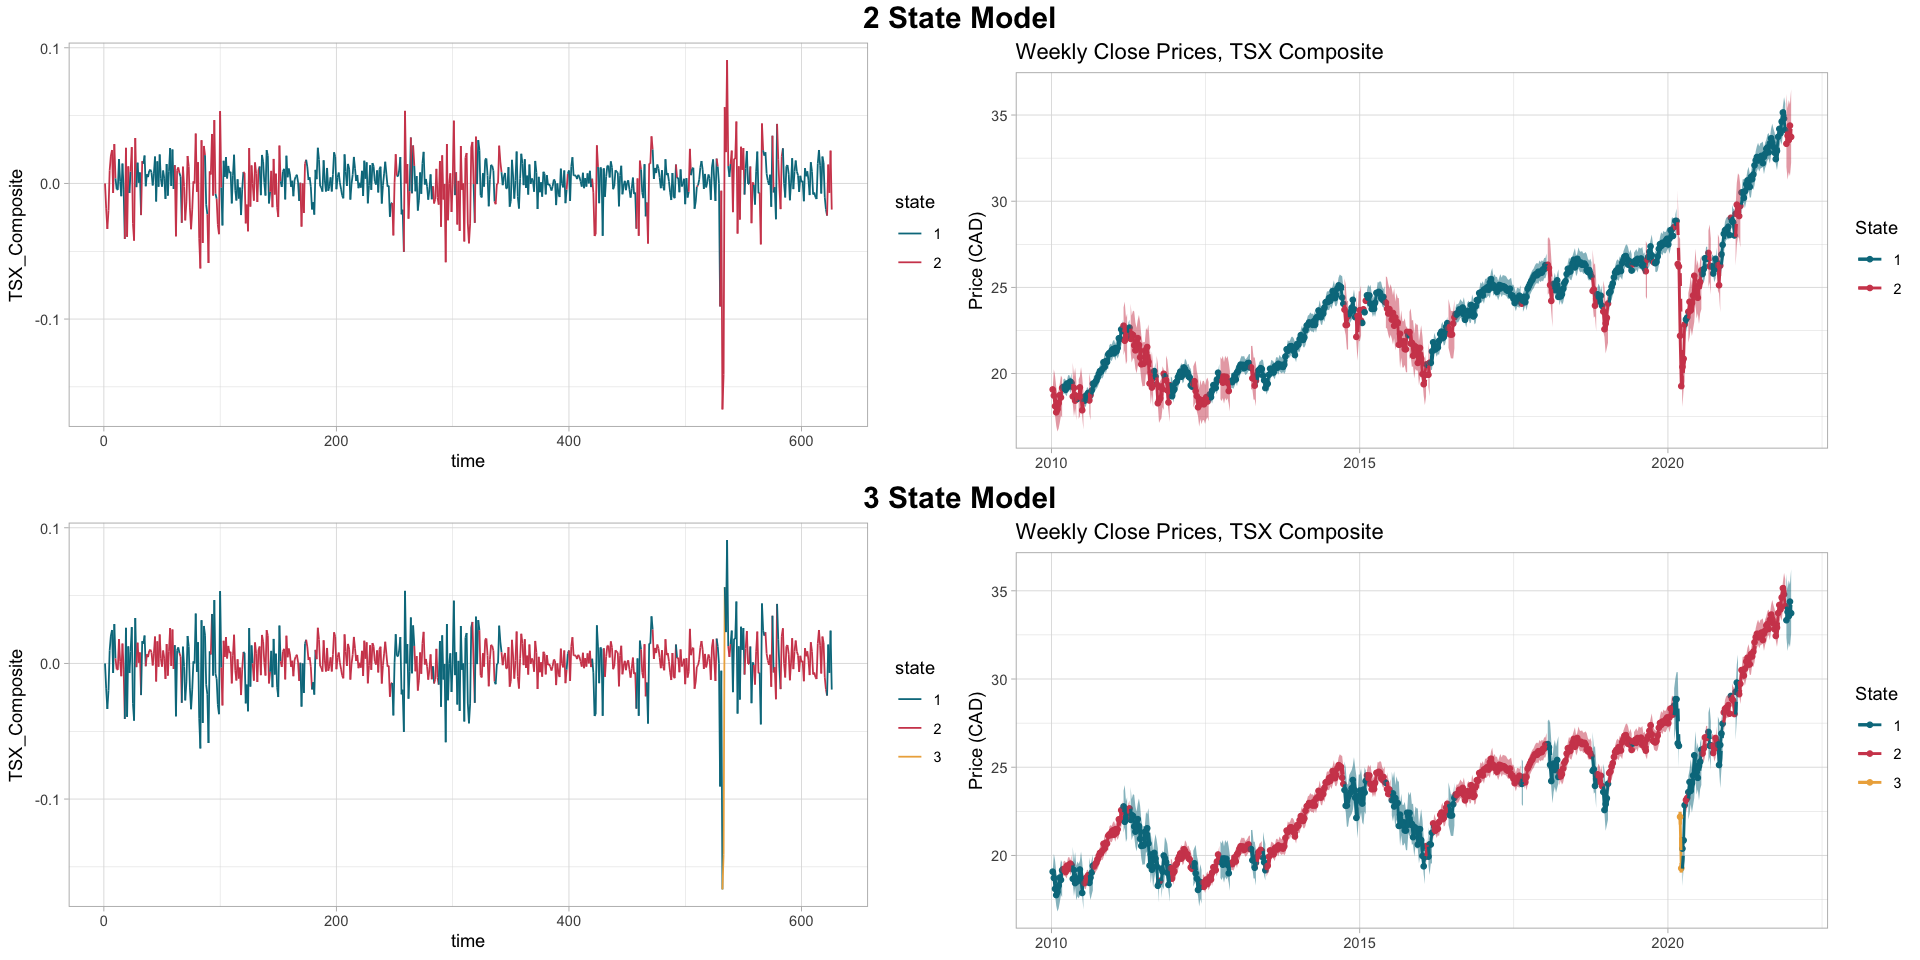

In [49]:
tsx_state_2s <- prepare_tsx_state_data(train_data, hmm_2s)
tsx_plot_2s  <- plot_tsx_state_series(tsx_state_2s, show = "both")
p_2s <- hmm_2s$plot_ts("TSX_Composite")

tsx_state_3s <- prepare_tsx_state_data(train_data, hmm_3s)
tsx_plot_3s  <- plot_tsx_state_series(tsx_state_3s, show = "both")
p_3s <- hmm_3s$plot_ts("TSX_Composite")

# options(repr.plot.width = 16, repr.plot.height = 8)  # Adjust figure size
# grid.arrange(p_2s, tsx_plot_2s, p_3s, tsx_plot_3s, ncol = 2)

library(gridExtra)
library(grid)

row_2s <- arrangeGrob(
  p_2s, tsx_plot_2s, ncol = 2,
  top = textGrob("2 State Model", gp = gpar(fontsize = 18, fontface = "bold"))
)

row_3s <- arrangeGrob(
  p_3s, tsx_plot_3s, ncol = 2,
  top = textGrob("3 State Model", gp = gpar(fontsize = 18, fontface = "bold"))
)

options(repr.plot.width = 16, repr.plot.height = 8)
grid.arrange(row_2s, row_3s, ncol = 1)


## With Horseshoe

In [132]:
load_all("../../../hmmTMB")

ℹ Loading hmmTMB


ℹ Re-compiling hmmTMB (debug build)



── R CMD INSTALL ───────────────────────────────────────────────────────────────
* installing *source* package ‘hmmTMB’ ...
** using staged installation
rm -rf *o
** libs
/opt/anaconda3/envs/hmm/lib/R/bin/Rscript --vanilla -e "invisible(TMB::compile('hmmTMB.cpp', safebounds = FALSE, safeunload = FALSE))"
Note: Using Makevars in /var/folders/1v/pf54418j6fj5541rk7ynqhgw0000gn/T//RtmpvTpNVc/fileda0445fb39f0 
using C++ compiler: ‘clang version 20.1.4’
using SDK: ‘MacOSX15.4.sdk’
make[1]: Entering directory '/Users/duncancs/Documents/Research/hmm_research/hmmTMB/src'
x86_64-apple-darwin13.4.0-clang++ -std=gnu++17 -I"/opt/anaconda3/envs/hmm/lib/R/include" -DNDEBUG -I"/opt/anaconda3/envs/hmm/lib/R/library/TMB/include" -I"/opt/anaconda3/envs/hmm/lib/R/library/RcppEigen/include"   -DTMB_EIGEN_DISABLE_WARNINGS   -DTMB_LIB_INIT=R_init_hmmTMB  -DCPPAD_FRAMEWORK -I'/opt/anaconda3/envs/hmm/lib/R/library/TMB/include' -I'/opt/anaconda3/envs/hmm/lib/R/library/RcppEigen/include' -D_FORTIFY_SOURCE=2 -isy

Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradient = args$gr, :
“NA/NaN function evaluation”
Warning message in nlminb(start = args$par, objective = args$fn, gradien

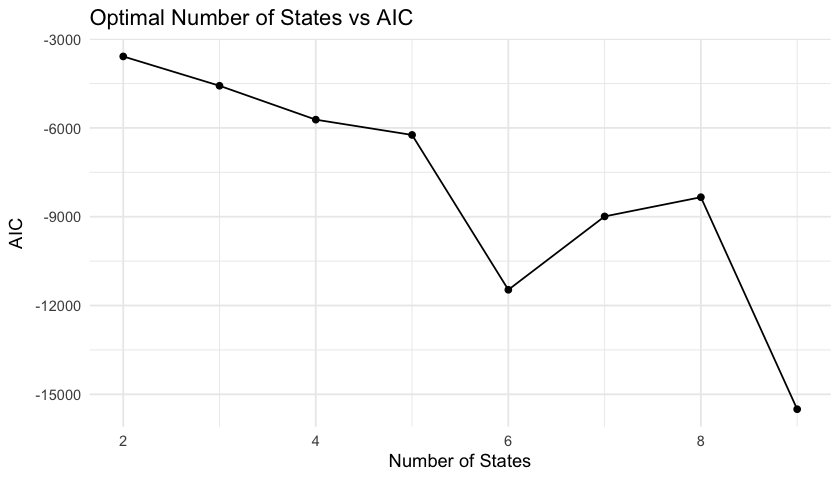

In [ ]:
optimal_n <- data.frame(
  n_states = integer(),
  AIC = numeric()
)
data <- train_data_scaled
cov_colnames <- setdiff(colnames(data), c("Date", observation))
hid_formula <- as.formula(paste("~1 +", paste(cov_colnames, collapse = " + ")))

for (n in 2:9) {
  hmm <- fit_markets_hmm(
    n_states = n,
    data = data,
    obs_name = observation,
    hid_formula = hid_formula,
    horseshoe = TRUE
    )
  optimal_n <- rbind(optimal_n, data.frame(n_states = n, AIC = hmm$AIC_conditional()))
}
options(repr.plot.width = 7, repr.plot.height = 4)  # Adjust figure size
ggplot(optimal_n, aes(x = n_states, y = AIC)) +
  geom_line() +
  geom_point() +
  labs(title = "Optimal Number of States vs AIC", x = "Number of States", y = "AIC") +
  theme_minimal()

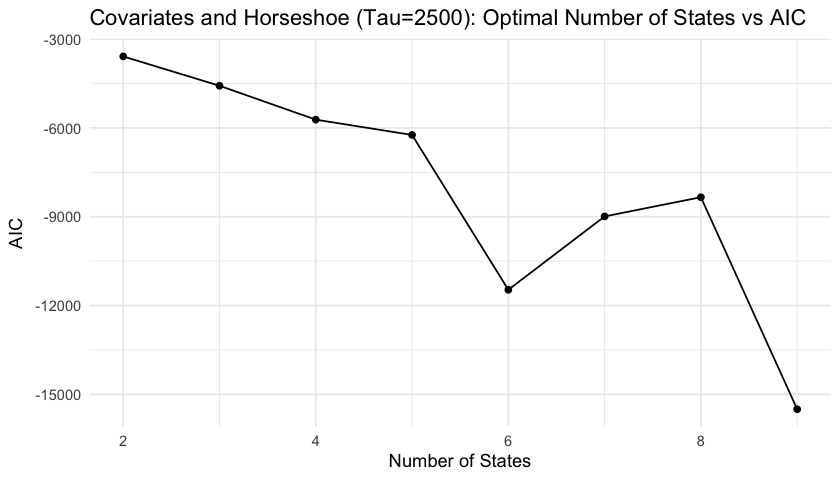

In [152]:
options(repr.plot.width = 7, repr.plot.height = 4)  # Adjust figure size
ggplot(optimal_n, aes(x = n_states, y = AIC)) +
  geom_line() +
  geom_point() +
  labs(title = "Covariates and Horseshoe (Tau=2500): Optimal Number of States vs AIC", x = "Number of States", y = "AIC") +
  theme_minimal()

In [206]:
hmm_2s <- fit_markets_hmm(
  n_states = 2,
  data = data,
  obs_name = observation,
  hid_formula = hid_formula,
  horseshoe = TRUE
)

hmm_3s <- fit_markets_hmm(
  n_states = 3,
  data = data,
  obs_name = observation,
  hid_formula = hid_formula,
  horseshoe = TRUE
)

hmm_4s <- fit_markets_hmm(
  n_states = 4,
  data = data,
  obs_name = observation,
  hid_formula = hid_formula,
  horseshoe = TRUE
)

# hmm_5s <- fit_markets_hmm(
#   n_states = 5,
#   data = data,
#   obs_name = observation,
#   hid_formula = hid_formula,
#   horseshoe = TRUE
# )

# hmm_6s <- fit_markets_hmm(
#   n_states = 6,
#   data = data,
#   obs_name = observation,
#   hid_formula = hid_formula,
#   horseshoe = TRUE
#)

Warning message in hmm$fit(silent = TRUE):
“Convergence code was not zero, indicating that the optimizer may not have converged to the correct estimates. Please check by consulting the out() function which shows what nlminb returned.”
Warning message in hmm$fit(silent = TRUE):
“Convergence code was not zero, indicating that the optimizer may not have converged to the correct estimates. Please check by consulting the out() function which shows what nlminb returned.”
Warning message in hmm$fit(silent = TRUE):
“Convergence code was not zero, indicating that the optimizer may not have converged to the correct estimates. Please check by consulting the out() function which shows what nlminb returned.”


In [207]:
extract_hid_fe <- function(hmm) {
  hid_fe <- hmm$hid()$coeff_fe()
  
  hid_fe <- data.frame(hid_fe)
  hid_fe$transition <- sapply(strsplit(rownames(hid_fe), "\\."), `[`, 1)
  hid_fe$covariate  <- sapply(strsplit(rownames(hid_fe), "\\."), `[`, 2)
  
  hid_fe_wide <- hid_fe %>%
    pivot_wider(names_from = covariate, values_from = hid_fe) %>%
    column_to_rownames("transition")
  
  return(hid_fe_wide)
}
hid_fe_2s <- extract_hid_fe(hmm_2s)
hid_fe_3s <- extract_hid_fe(hmm_3s)
hid_fe_4s <- extract_hid_fe(hmm_4s)
hid_fe_5s <- extract_hid_fe(hmm_5s)
hid_fe_6s <- extract_hid_fe(hmm_6s)


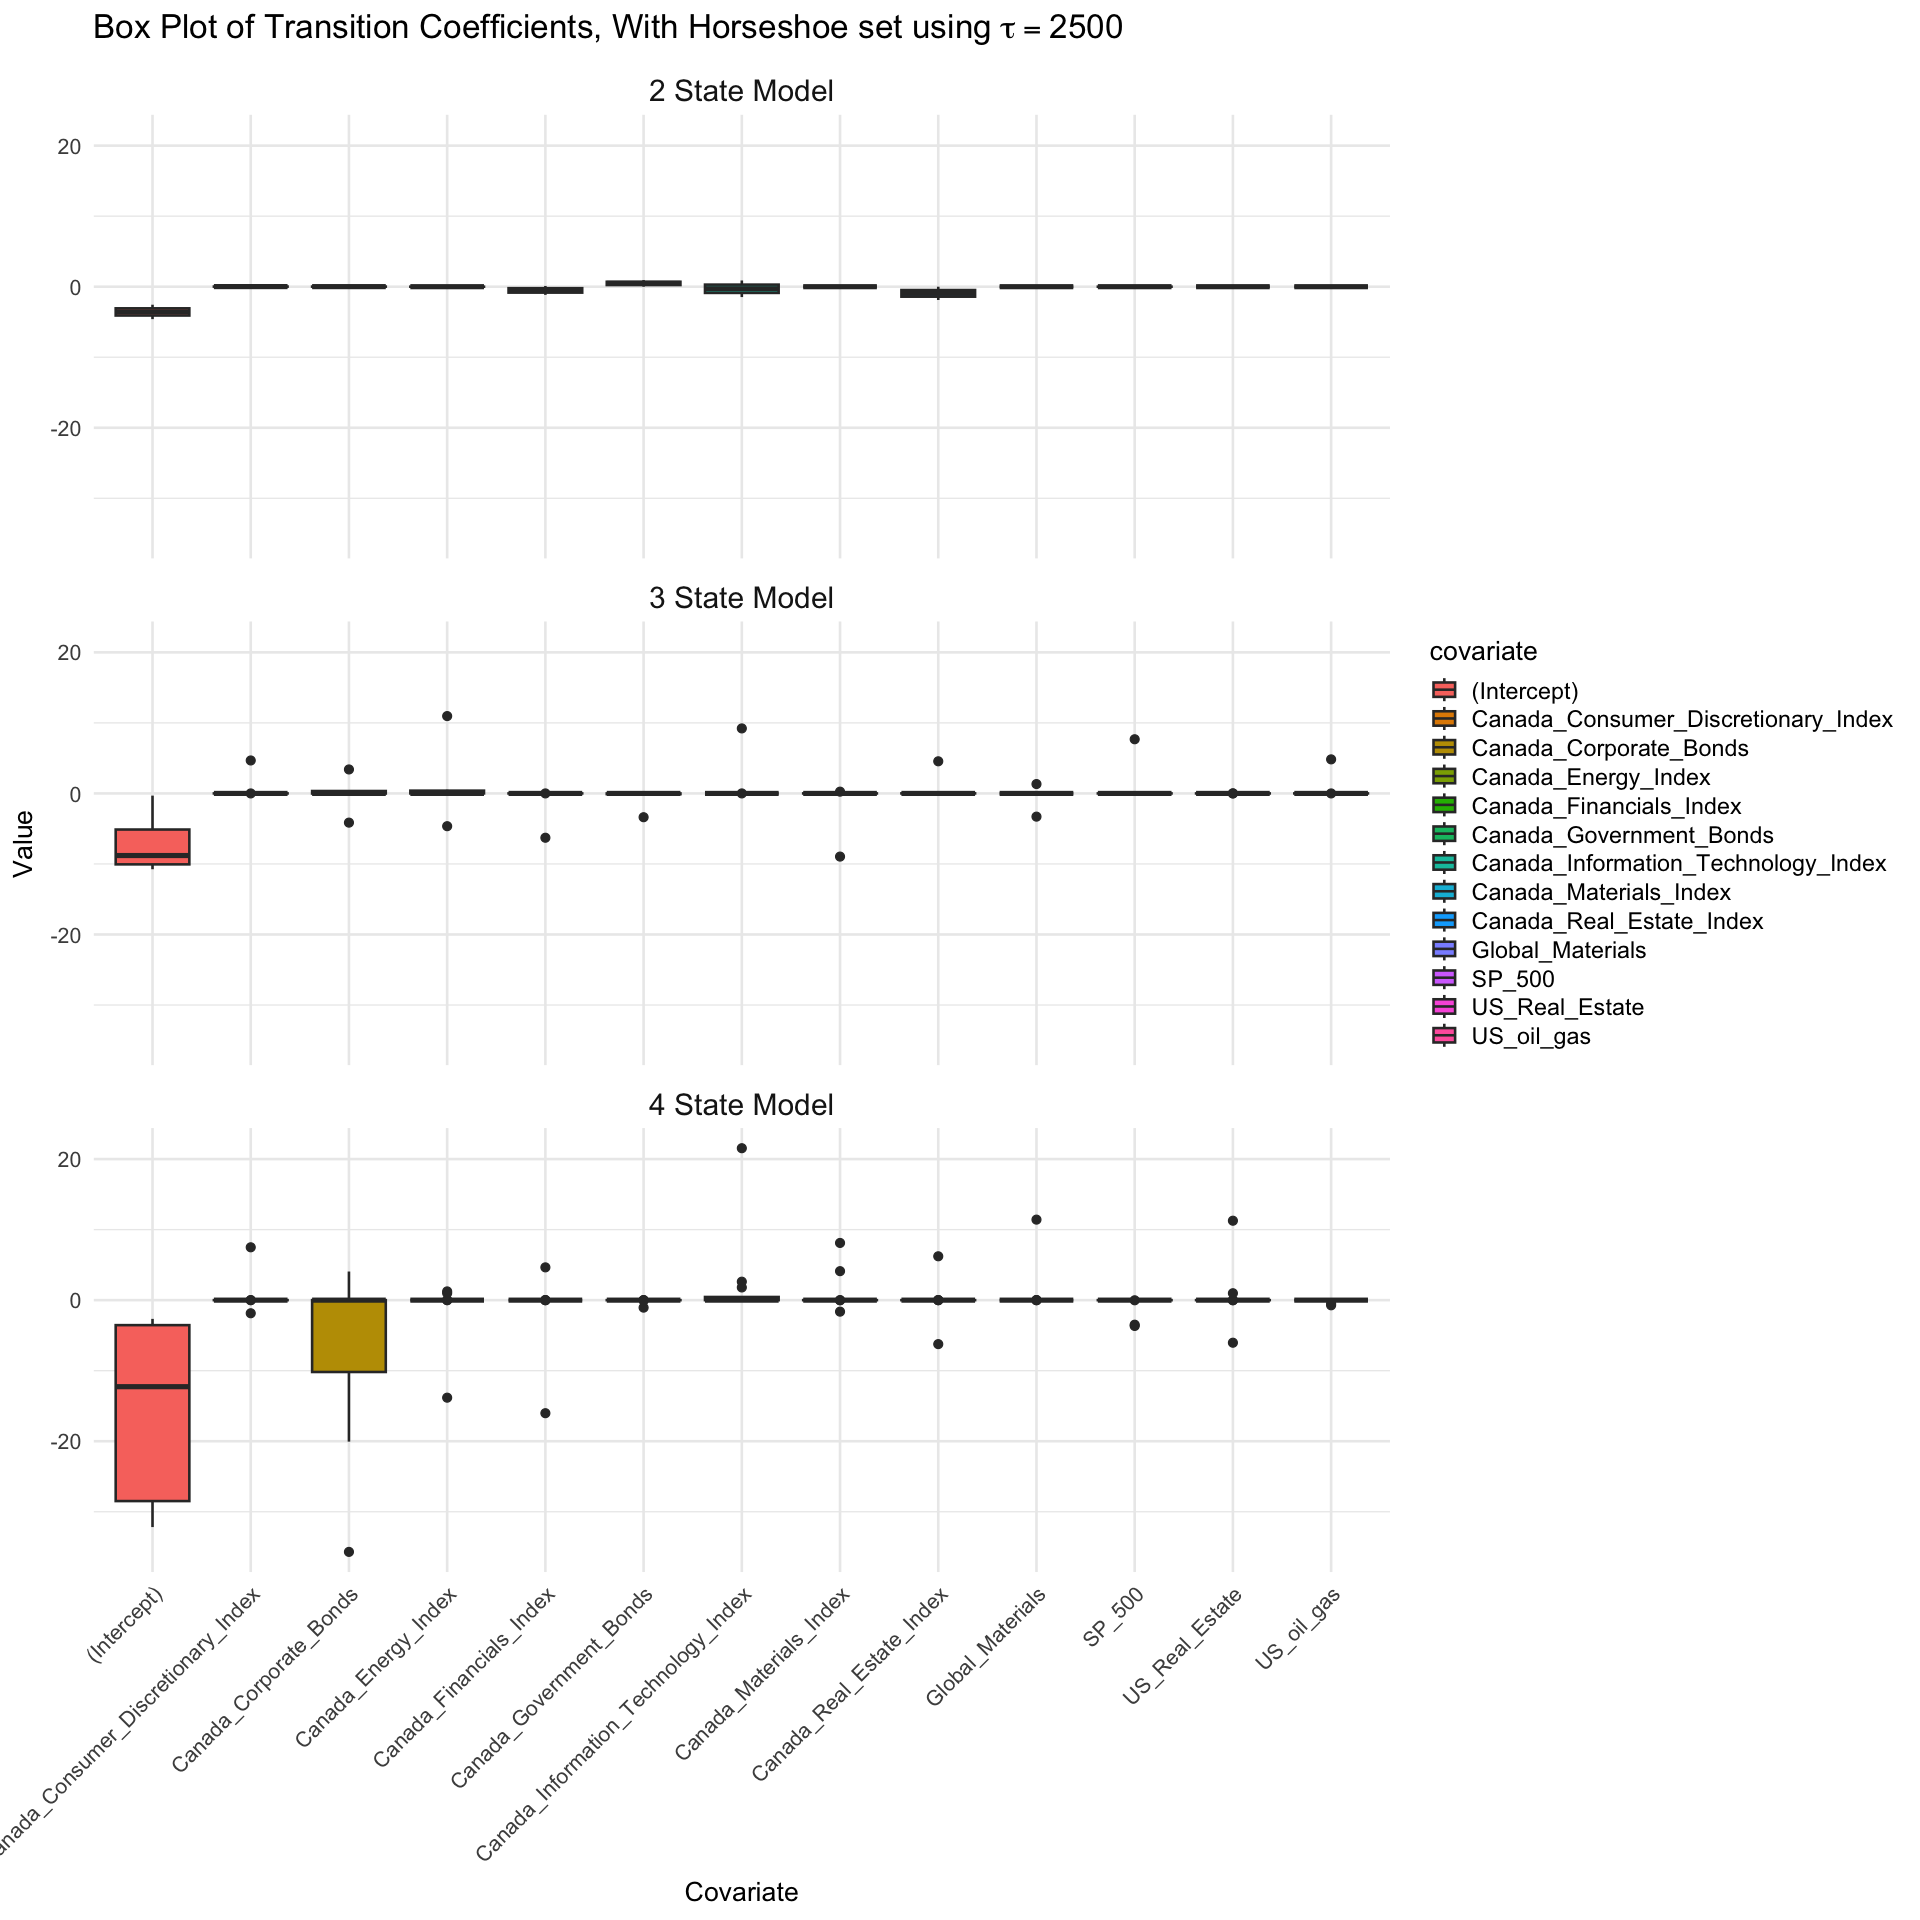

In [208]:
hid_fe_to_long <- function(hid_fe, model_label) {
  hid_fe %>%
    rownames_to_column("transition") %>%
    pivot_longer(-transition, names_to = "covariate", values_to = "value") %>%
    mutate(model = model_label)
}

hid_fe_long <- bind_rows(
  hid_fe_to_long(hid_fe_2s, "2 State Model"),
  hid_fe_to_long(hid_fe_3s, "3 State Model"),
  hid_fe_to_long(hid_fe_4s, "4 State Model")
) %>%
  mutate(model = factor(model, levels = c("2 State Model", "3 State Model", "4 State Model")))

# Plot the boxplot
options(repr.plot.width = 16, repr.plot.height = 16)  # Adjust figure size
ggplot(hid_fe_long, aes(x = covariate, y = value, fill = covariate)) +
  geom_boxplot() +
  facet_wrap(~ model, ncol = 1) +
  labs(title = expression("Box Plot of Transition Coefficients, With Horseshoe set using " * tau == 2500), x = "Covariate", y = "Value") +
  theme_minimal(base_size = 16) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        strip.text = element_text(size = 18),
        plot.title = element_text(size = 20, face = "bold"),
        legend.title = element_text(size = 16),
        legend.text = element_text(size = 14))

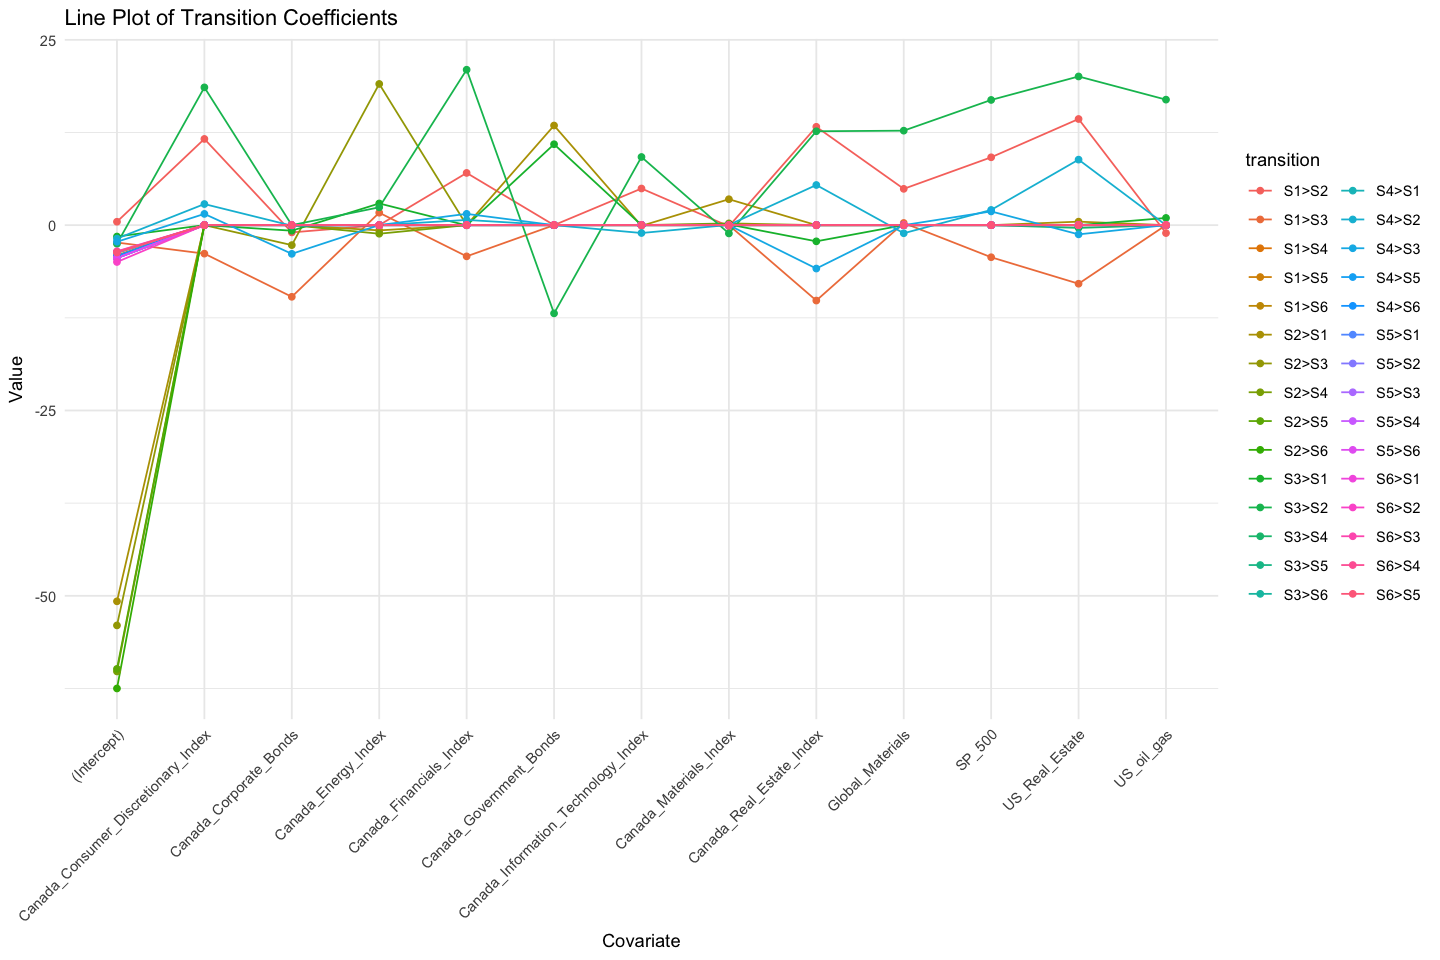

In [165]:
# Plot the line plot
options(repr.plot.width = 12, repr.plot.height = 8)  # Adjust figure size
ggplot(hid_fe_6s_long, aes(x = covariate, y = value, group = transition, color = transition)) +
  geom_line() +
  geom_point() +
  labs(title = "Line Plot of Transition Coefficients", x = "Covariate", y = "Value") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

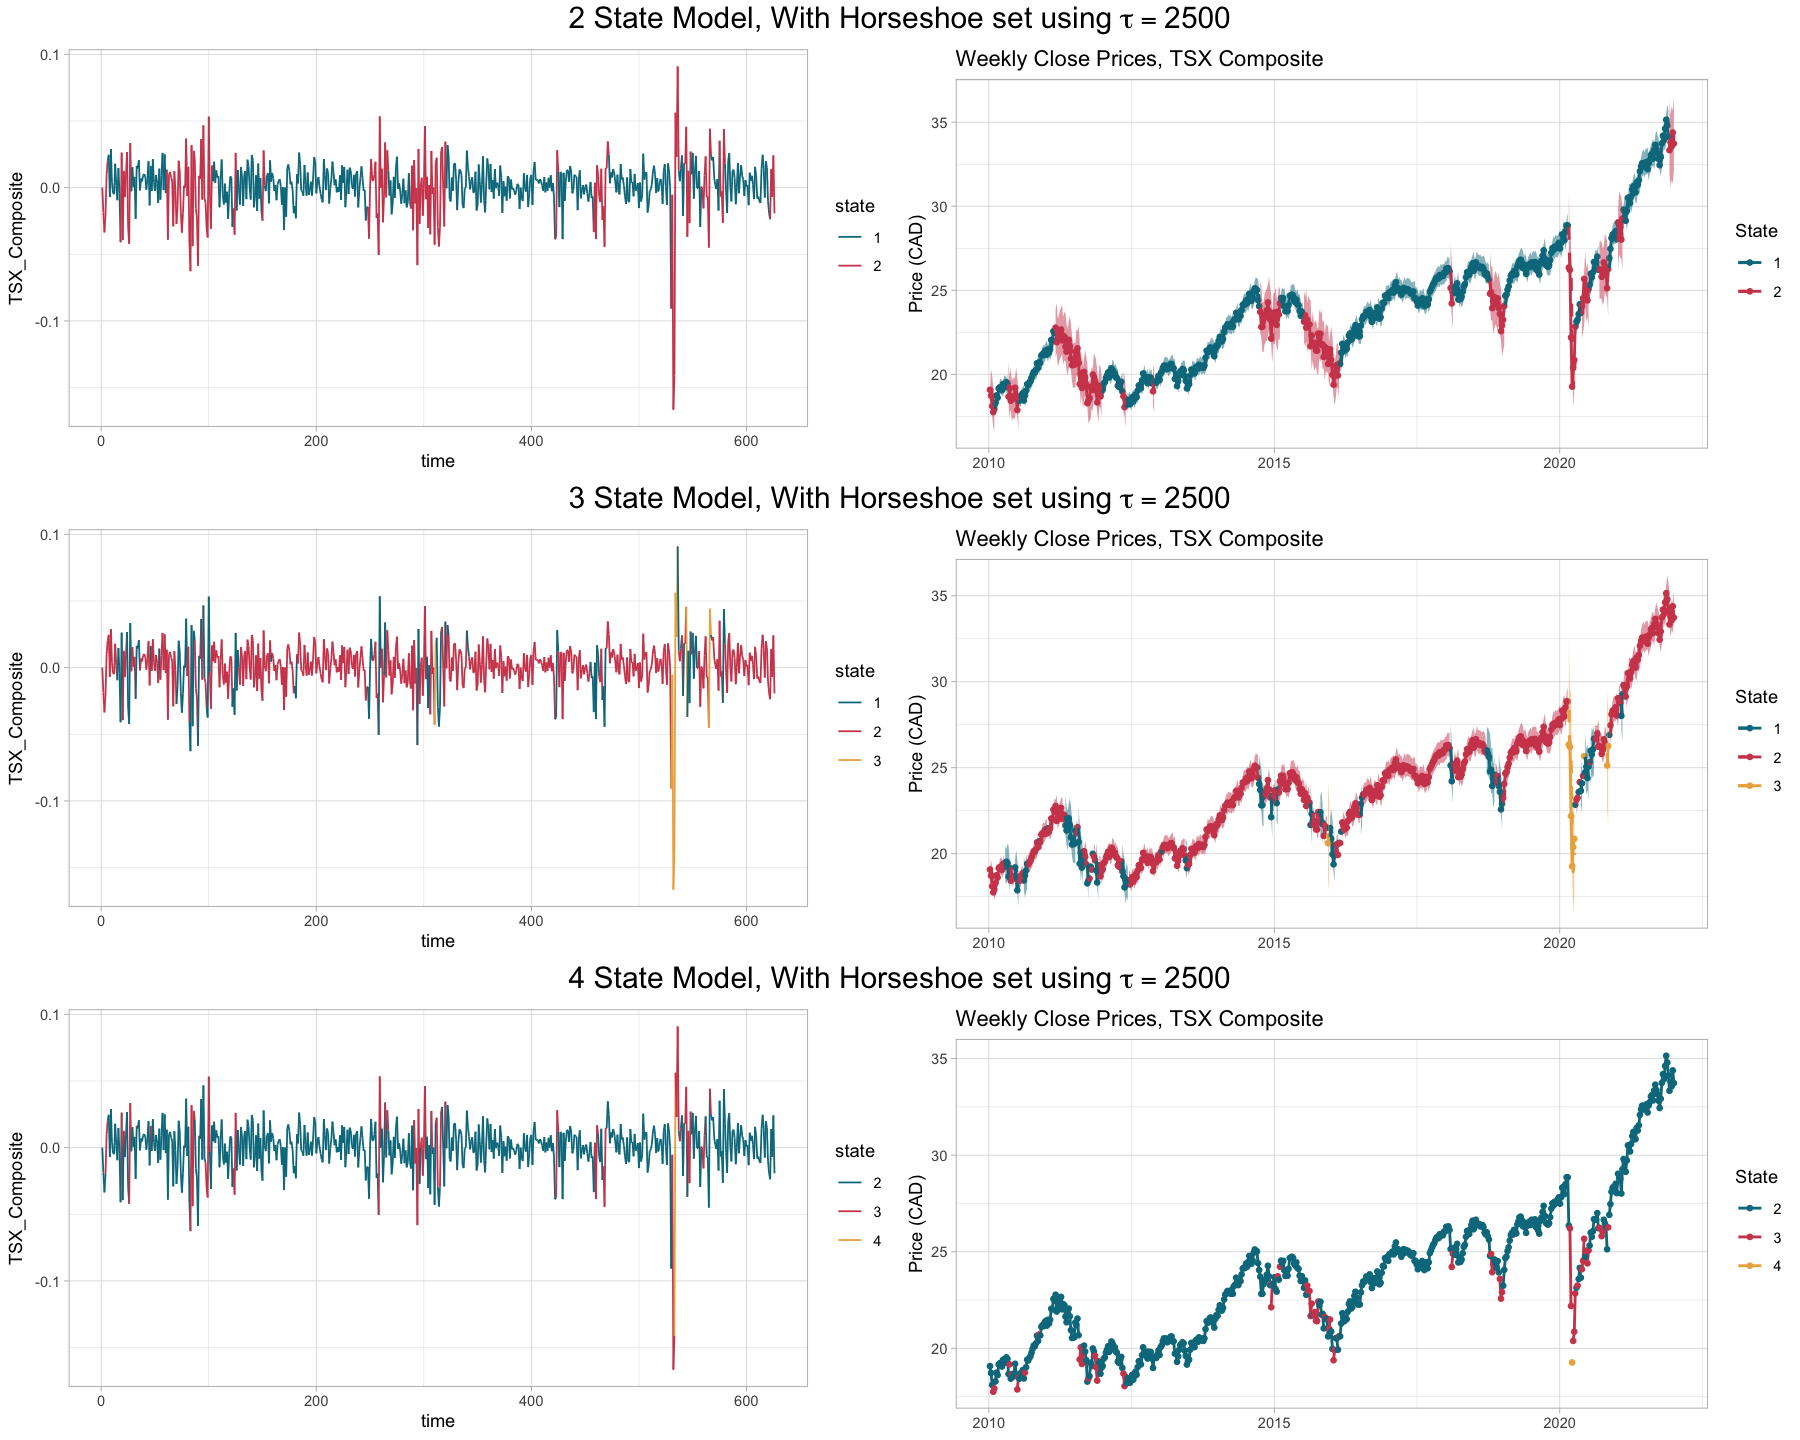

In [209]:
tsx_state_2s <- prepare_tsx_state_data(train_data, hmm_2s)
tsx_plot_2s  <- plot_tsx_state_series(tsx_state_2s, show = "both")
p_2s <- hmm_2s$plot_ts("TSX_Composite")

tsx_state_3s <- prepare_tsx_state_data(train_data, hmm_3s)
tsx_plot_3s  <- plot_tsx_state_series(tsx_state_3s, show = "both")
p_3s <- hmm_3s$plot_ts("TSX_Composite")

tsx_state_4s <- prepare_tsx_state_data(train_data, hmm_4s)
tsx_plot_4s  <- plot_tsx_state_series(tsx_state_4s, show = "states")
p_4s <- hmm_4s$plot_ts("TSX_Composite")

tsx_state_5s <- prepare_tsx_state_data(train_data, hmm_5s)
tsx_plot_5s  <- plot_tsx_state_series(tsx_state_5s, show = "both")
p_5s <- hmm_5s$plot_ts("TSX_Composite")

tsx_state_6s <- prepare_tsx_state_data(train_data, hmm_6s)
tsx_plot_6s  <- plot_tsx_state_series(tsx_state_6s, show = "both")
p_6s <- hmm_6s$plot_ts("TSX_Composite")

row_2s <- arrangeGrob(
  p_2s, tsx_plot_2s, ncol = 2,
  top = textGrob(expression("2 State Model, With Horseshoe set using " * tau == 2500), gp = gpar(fontsize = 18, fontface = "bold"))
)

row_3s <- arrangeGrob(
  p_3s, tsx_plot_3s, ncol = 2,
  top = textGrob(expression("3 State Model, With Horseshoe set using " * tau == 2500), gp = gpar(fontsize = 18, fontface = "bold"))
)

row_4s <- arrangeGrob(
  p_4s, tsx_plot_4s, ncol = 2,
  top = textGrob(expression("4 State Model, With Horseshoe set using " * tau == 2500), gp = gpar(fontsize = 18, fontface = "bold"))
)

row_5s <- arrangeGrob(
  p_5s, tsx_plot_5s, ncol = 2,
  top = textGrob(expression("5 State Model, With Horseshoe set using " * tau == 2500), gp = gpar(fontsize = 18, fontface = "bold"))
)

row_6s <- arrangeGrob(
  p_6s, tsx_plot_6s, ncol = 2,
  top = textGrob(expression("6 State Model, With Horseshoe set using " * tau == 2500), gp = gpar(fontsize = 18, fontface = "bold"))
)

options(repr.plot.width = 15, repr.plot.height = 12)
grid.arrange(row_2s, row_3s, row_4s, ncol = 1)


In [199]:
hmm_4s$print_obspar()

> Estimated observation parameters (t = 1):
                   state 1 state 2 state 3 state 4
TSX_Composite.mean  20.697   0.002   0.000  -1.816
TSX_Composite.sd     0.017   0.015   0.038   2.034



In [163]:
hmm_6s$print_obspar()

> Estimated observation parameters (t = 1):
                     state 1 state 2 state 3      state 4 state 5 state 6
TSX_Composite.mean   -11.403   0.001   8.784 3.926600e+01  30.616  19.971
TSX_Composite.sd   19723.275   0.017   9.165 3.036085e+31   0.000   2.662

